In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report
from itertools import product
from tqdm import tqdm


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcuskrarup/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load data

In [3]:
# Import Ekman emotions to DataFrame
df_train_ekman = pd.read_csv('data/ekman_train.csv')
df_val_ekman = pd.read_csv('data/ekman_val.csv')
df_test_ekman = pd.read_csv('data/ekman_test.csv')



In [4]:
# Count occurrences for each emotion in train, test, and val datasets
train_counts = df_train_ekman.iloc[:, 1:].sum()
test_counts = df_test_ekman.iloc[:, 1:].sum()
val_counts = df_val_ekman.iloc[:, 1:].sum()

print("Train Counts:\n", train_counts)
print("\nTest Counts:\n", test_counts)
print("\nValidation Counts:\n", val_counts)

Train Counts:
 anger        4907
disgust       838
fear          719
joy         13936
neutral      9544
sadness      3016
surprise     4895
dtype: int64

Test Counts:
 anger       1588
disgust      258
fear         254
joy         4728
neutral     3144
sadness     1010
surprise    1608
dtype: int64

Validation Counts:
 anger       1662
disgust      265
fear         255
joy         4672
neutral     3117
sadness     1017
surprise    1659
dtype: int64


# Text preprocessing

In [5]:
def preprocess(text):
    return word_tokenize(text.lower())

# Build vocab

In [6]:
tokenized_texts = df_train_ekman['text'].apply(preprocess)
word_counts = Counter(token for tokens in tokenized_texts for token in tokens)
vocab = {word: i + 2 for i, (word, _) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(text):
    return [vocab.get(t, vocab['<UNK>']) for t in preprocess(text)]

# Dataset

In [7]:
class EmotionDataset(Dataset):
    def __init__(self, df):
        self.X = [torch.tensor(encode(text)) for text in df['text']]
        self.y = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded_seqs, torch.stack(labels)

train_loader = DataLoader(EmotionDataset(df_train_ekman), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(EmotionDataset(df_val_ekman), batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(EmotionDataset(df_test_ekman), batch_size=32, collate_fn=collate_fn)

# Model

In [8]:
class EmotionLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return self.sigmoid(out)

# Initialize

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionLSTM(len(vocab), embed_dim=100, hidden_dim=128, output_dim=7).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop

In [10]:
for epoch in range(5):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 406.2104
Epoch 2, Loss: 370.5895
Epoch 3, Loss: 336.3204
Epoch 4, Loss: 312.0397
Epoch 5, Loss: 286.1585


# Evaluation (Validation or Test)

In [11]:
for epoch in range(5):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 256.0915
Epoch 2, Loss: 224.4679
Epoch 3, Loss: 194.2492
Epoch 4, Loss: 167.4298
Epoch 5, Loss: 145.1787


In [12]:
def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            preds = (preds > 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += torch.numel(y_batch)
    print(f"Accuracy: {correct / total:.4f}")

In [13]:
evaluate(
    model = model.to(device),
    data_loader = val_loader,  
    criterion = criterion,
    device = device,
)

TypeError: evaluate() got an unexpected keyword argument 'model'

In [14]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

In [15]:
epochs = 5  # Define the number of epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Accuracy
        predicted = (preds > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += torch.numel(y_batch)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total * 100

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()
            predicted = (preds > 0.5).float()
            val_correct += (predicted == y_batch).sum().item()
            val_total += torch.numel(y_batch)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total * 100

    # Record history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


Epoch 1/5 | Train Loss: 0.1169, Val Loss: 0.4924, Train Acc: 95.89%, Val Acc: 84.96%
Epoch 2/5 | Train Loss: 0.1023, Val Loss: 0.5111, Train Acc: 96.47%, Val Acc: 85.07%
Epoch 3/5 | Train Loss: 0.0905, Val Loss: 0.5498, Train Acc: 96.90%, Val Acc: 85.06%
Epoch 4/5 | Train Loss: 0.0804, Val Loss: 0.5659, Train Acc: 97.30%, Val Acc: 84.71%
Epoch 5/5 | Train Loss: 0.0719, Val Loss: 0.5984, Train Acc: 97.59%, Val Acc: 84.44%


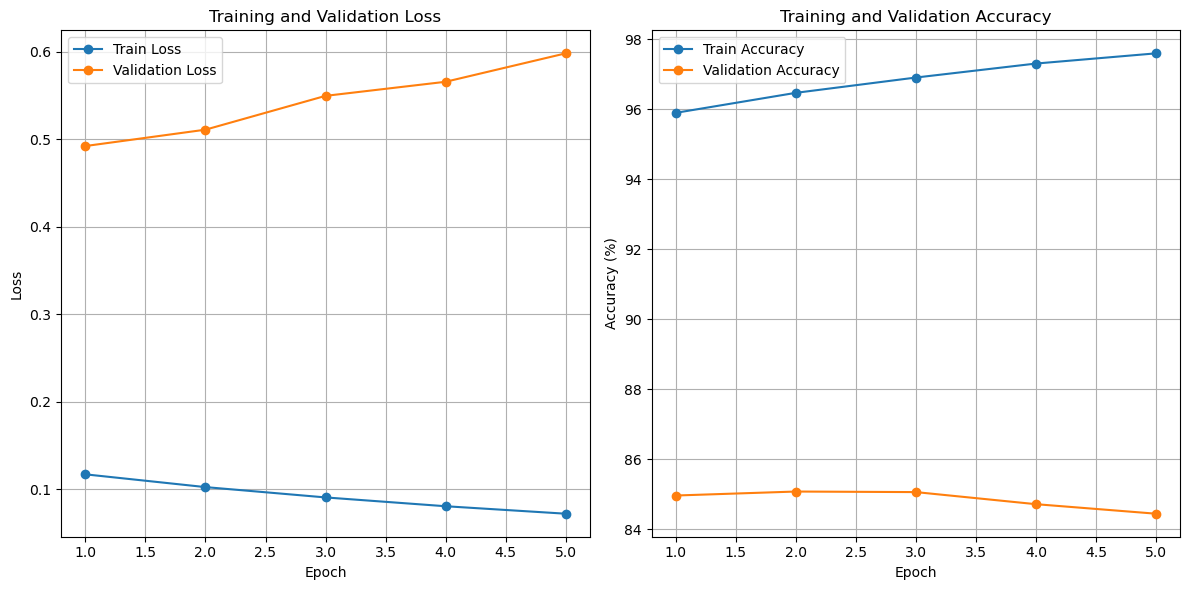

In [16]:
def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [17]:
print("Test:")
evaluate(test_loader)

Test:
Accuracy: 0.8423


In [18]:
from sklearn.metrics import classification_report

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = (outputs > 0.5).float()

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert to arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Emotion class names in order
class_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Print classification report
print("\nClassification Report (Multi-label):")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))



Classification Report (Multi-label):
              precision    recall  f1-score   support

       anger       0.36      0.31      0.33      1588
     disgust       0.23      0.10      0.14       258
        fear       0.31      0.13      0.18       254
         joy       0.66      0.65      0.66      4728
     neutral       0.40      0.39      0.40      3144
     sadness       0.42      0.30      0.35      1010
    surprise       0.36      0.39      0.37      1608

   micro avg       0.49      0.46      0.48     12590
   macro avg       0.39      0.32      0.35     12590
weighted avg       0.49      0.46      0.47     12590
 samples avg       0.47      0.47      0.46     12590



In [19]:
import numpy as np
from sklearn.metrics import classification_report

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = (outputs > 0.5).float()
        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

class_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

print("\nClassification Report (Multi-label):")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))



Classification Report (Multi-label):
              precision    recall  f1-score   support

       anger       0.36      0.31      0.33      1588
     disgust       0.23      0.10      0.14       258
        fear       0.31      0.13      0.18       254
         joy       0.66      0.65      0.66      4728
     neutral       0.40      0.39      0.40      3144
     sadness       0.42      0.30      0.35      1010
    surprise       0.36      0.39      0.37      1608

   micro avg       0.49      0.46      0.48     12590
   macro avg       0.39      0.32      0.35     12590
weighted avg       0.49      0.46      0.47     12590
 samples avg       0.47      0.47      0.46     12590



# Hyperparameter tuning

In [20]:
def run_grid_search(df_train_ekman, df_val_ekman, vocab):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_config = None
    best_val_acc = 0
    best_history = None
    best_model = None

    # Hyperparameter grid
    hidden_dims = [64, 128]
    batch_sizes = [16, 32]
    epochs_list = [3, 10]

    for hidden_dim, batch_size, epochs in tqdm(product(hidden_dims, batch_sizes, epochs_list), total=8):
        print(f"\nTraining: hidden_dim={hidden_dim}, batch_size={batch_size}, epochs={epochs}")

        train_loader = DataLoader(EmotionDataset(df_train_ekman), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(EmotionDataset(df_val_ekman), batch_size=batch_size, collate_fn=collate_fn)

        model = EmotionLSTM(len(vocab), embed_dim=100, hidden_dim=hidden_dim, output_dim=7).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

        for epoch in range(epochs):
            model.train()
            total_loss = 0
            correct, total = 0, 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                predicted = (preds > 0.5).float()
                correct += (predicted == y_batch).sum().item()
                total += torch.numel(y_batch)

            train_loss = total_loss / len(train_loader)
            train_acc = correct / total * 100

            model.eval()
            val_loss, val_correct, val_total = 0, 0, 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    preds = model(X_batch)
                    val_loss += criterion(preds, y_batch).item()
                    predicted = (preds > 0.5).float()
                    val_correct += (predicted == y_batch).sum().item()
                    val_total += torch.numel(y_batch)

            val_loss /= len(val_loader)
            val_acc = val_correct / val_total * 100

            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            history["train_acc"].append(train_acc)
            history["val_acc"].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config = (hidden_dim, batch_size, epochs)
            best_history = {
                "train_loss": history["train_loss"].copy(),
                "val_loss": history["val_loss"].copy(),
                "train_acc": history["train_acc"].copy(),
                "val_acc": history["val_acc"].copy()
            }
            best_model = model

    print("\n✅ Best configuration:")
    print(f"Hidden Dim: {best_config[0]}, Batch Size: {best_config[1]}, Epochs: {best_config[2]}")
    print(f"Validation Accuracy: {best_val_acc:.2f}%")

    return best_config, best_history, best_model


In [21]:
run_grid_search(df_train_ekman, df_val_ekman, vocab)



  0%|          | 0/8 [00:00<?, ?it/s]


Training: hidden_dim=64, batch_size=16, epochs=3
Epoch 1/3 | Train Loss: 0.3699, Val Loss: 0.3629, Train Acc: 84.49%, Val Acc: 84.93%
Epoch 2/3 | Train Loss: 0.3550, Val Loss: 0.3538, Train Acc: 85.32%, Val Acc: 85.53%


 12%|█▎        | 1/8 [00:58<06:47, 58.20s/it]

Epoch 3/3 | Train Loss: 0.3430, Val Loss: 0.3508, Train Acc: 85.96%, Val Acc: 85.73%

Training: hidden_dim=64, batch_size=16, epochs=10
Epoch 1/10 | Train Loss: 0.3687, Val Loss: 0.3595, Train Acc: 84.52%, Val Acc: 85.26%
Epoch 2/10 | Train Loss: 0.3511, Val Loss: 0.3515, Train Acc: 85.63%, Val Acc: 85.59%
Epoch 3/10 | Train Loss: 0.3382, Val Loss: 0.3533, Train Acc: 86.24%, Val Acc: 85.42%
Epoch 4/10 | Train Loss: 0.3300, Val Loss: 0.3506, Train Acc: 86.64%, Val Acc: 85.80%
Epoch 5/10 | Train Loss: 0.3229, Val Loss: 0.3536, Train Acc: 86.95%, Val Acc: 85.57%
Epoch 6/10 | Train Loss: 0.3176, Val Loss: 0.3598, Train Acc: 87.26%, Val Acc: 85.08%
Epoch 7/10 | Train Loss: 0.3122, Val Loss: 0.3579, Train Acc: 87.51%, Val Acc: 85.33%
Epoch 8/10 | Train Loss: 0.3102, Val Loss: 0.3603, Train Acc: 87.59%, Val Acc: 85.20%
Epoch 9/10 | Train Loss: 0.3067, Val Loss: 0.3693, Train Acc: 87.76%, Val Acc: 84.98%


 25%|██▌       | 2/8 [04:16<14:02, 140.36s/it]

Epoch 10/10 | Train Loss: 0.3026, Val Loss: 0.3655, Train Acc: 87.98%, Val Acc: 85.16%

Training: hidden_dim=64, batch_size=32, epochs=3
Epoch 1/3 | Train Loss: 0.3703, Val Loss: 0.3625, Train Acc: 84.44%, Val Acc: 84.92%
Epoch 2/3 | Train Loss: 0.3543, Val Loss: 0.3478, Train Acc: 85.41%, Val Acc: 85.90%


 38%|███▊      | 3/8 [04:52<07:44, 92.98s/it] 

Epoch 3/3 | Train Loss: 0.3331, Val Loss: 0.3403, Train Acc: 86.56%, Val Acc: 86.45%

Training: hidden_dim=64, batch_size=32, epochs=10
Epoch 1/10 | Train Loss: 0.3724, Val Loss: 0.3636, Train Acc: 84.31%, Val Acc: 84.77%
Epoch 2/10 | Train Loss: 0.3528, Val Loss: 0.3475, Train Acc: 85.51%, Val Acc: 86.00%
Epoch 3/10 | Train Loss: 0.3328, Val Loss: 0.3367, Train Acc: 86.61%, Val Acc: 86.43%
Epoch 4/10 | Train Loss: 0.3166, Val Loss: 0.3340, Train Acc: 87.23%, Val Acc: 86.53%
Epoch 5/10 | Train Loss: 0.3044, Val Loss: 0.3357, Train Acc: 87.74%, Val Acc: 86.44%
Epoch 6/10 | Train Loss: 0.2943, Val Loss: 0.3402, Train Acc: 88.25%, Val Acc: 86.09%
Epoch 7/10 | Train Loss: 0.2864, Val Loss: 0.3449, Train Acc: 88.57%, Val Acc: 86.19%
Epoch 8/10 | Train Loss: 0.2787, Val Loss: 0.3472, Train Acc: 88.93%, Val Acc: 86.18%
Epoch 9/10 | Train Loss: 0.2726, Val Loss: 0.3492, Train Acc: 89.25%, Val Acc: 86.08%


 50%|█████     | 4/8 [06:49<06:49, 102.28s/it]

Epoch 10/10 | Train Loss: 0.2664, Val Loss: 0.3579, Train Acc: 89.53%, Val Acc: 85.71%

Training: hidden_dim=128, batch_size=16, epochs=3
Epoch 1/3 | Train Loss: 0.3677, Val Loss: 0.3567, Train Acc: 84.58%, Val Acc: 85.39%
Epoch 2/3 | Train Loss: 0.3494, Val Loss: 0.3474, Train Acc: 85.77%, Val Acc: 85.98%


 62%|██████▎   | 5/8 [08:08<04:42, 94.08s/it] 

Epoch 3/3 | Train Loss: 0.3359, Val Loss: 0.3438, Train Acc: 86.36%, Val Acc: 86.13%

Training: hidden_dim=128, batch_size=16, epochs=10
Epoch 1/10 | Train Loss: 0.3652, Val Loss: 0.3557, Train Acc: 84.71%, Val Acc: 85.51%
Epoch 2/10 | Train Loss: 0.3459, Val Loss: 0.3499, Train Acc: 85.94%, Val Acc: 85.77%
Epoch 3/10 | Train Loss: 0.3348, Val Loss: 0.3457, Train Acc: 86.44%, Val Acc: 86.03%
Epoch 4/10 | Train Loss: 0.3246, Val Loss: 0.3485, Train Acc: 86.85%, Val Acc: 85.98%
Epoch 5/10 | Train Loss: 0.3201, Val Loss: 0.3454, Train Acc: 87.08%, Val Acc: 85.98%
Epoch 6/10 | Train Loss: 0.3155, Val Loss: 0.3490, Train Acc: 87.26%, Val Acc: 85.81%
Epoch 7/10 | Train Loss: 0.3104, Val Loss: 0.3483, Train Acc: 87.46%, Val Acc: 85.85%
Epoch 8/10 | Train Loss: 0.3062, Val Loss: 0.3554, Train Acc: 87.71%, Val Acc: 85.83%
Epoch 9/10 | Train Loss: 0.3034, Val Loss: 0.3540, Train Acc: 87.89%, Val Acc: 85.47%


 75%|███████▌  | 6/8 [12:30<05:02, 151.13s/it]

Epoch 10/10 | Train Loss: 0.3005, Val Loss: 0.3536, Train Acc: 88.00%, Val Acc: 85.63%

Training: hidden_dim=128, batch_size=32, epochs=3
Epoch 1/3 | Train Loss: 0.3722, Val Loss: 0.3642, Train Acc: 84.33%, Val Acc: 84.77%
Epoch 2/3 | Train Loss: 0.3492, Val Loss: 0.3364, Train Acc: 85.77%, Val Acc: 86.52%


 88%|████████▊ | 7/8 [13:36<02:03, 123.12s/it]

Epoch 3/3 | Train Loss: 0.3280, Val Loss: 0.3323, Train Acc: 86.90%, Val Acc: 86.74%

Training: hidden_dim=128, batch_size=32, epochs=10
Epoch 1/10 | Train Loss: 0.3715, Val Loss: 0.3605, Train Acc: 84.43%, Val Acc: 85.05%
Epoch 2/10 | Train Loss: 0.3493, Val Loss: 0.3410, Train Acc: 85.66%, Val Acc: 86.10%
Epoch 3/10 | Train Loss: 0.3288, Val Loss: 0.3323, Train Acc: 86.60%, Val Acc: 86.53%
Epoch 4/10 | Train Loss: 0.3144, Val Loss: 0.3296, Train Acc: 87.24%, Val Acc: 86.50%
Epoch 5/10 | Train Loss: 0.3035, Val Loss: 0.3316, Train Acc: 87.71%, Val Acc: 86.47%
Epoch 6/10 | Train Loss: 0.2949, Val Loss: 0.3332, Train Acc: 88.13%, Val Acc: 86.20%
Epoch 7/10 | Train Loss: 0.2871, Val Loss: 0.3355, Train Acc: 88.50%, Val Acc: 86.27%
Epoch 8/10 | Train Loss: 0.2789, Val Loss: 0.3357, Train Acc: 88.90%, Val Acc: 86.26%
Epoch 9/10 | Train Loss: 0.2728, Val Loss: 0.3387, Train Acc: 89.16%, Val Acc: 86.19%


100%|██████████| 8/8 [17:01<00:00, 127.68s/it]

Epoch 10/10 | Train Loss: 0.2654, Val Loss: 0.3445, Train Acc: 89.55%, Val Acc: 86.01%

✅ Best configuration:
Hidden Dim: 128, Batch Size: 32, Epochs: 3
Validation Accuracy: 86.74%


((128, 32, 3),
 {'train_loss': [0.3721730939954492, 0.3491781049047701, 0.3280113971244375],
  'val_loss': [0.36420451174812635, 0.33643596836074235, 0.3323237653666916],
  'train_acc': [84.33388598813855, 85.7732630554387, 86.89836925589567],
  'val_acc': [84.76652396624681, 86.52347133206305, 86.73504738808741]},
 EmotionLSTM(
   (embedding): Embedding(25934, 100, padding_idx=0)
   (lstm): LSTM(100, 128, batch_first=True)
   (fc): Linear(in_features=128, out_features=7, bias=True)
   (sigmoid): Sigmoid()
 ))

  0%|          | 0/8 [00:00<?, ?it/s]


Training: hidden_dim=64, batch_size=16, epochs=3
Epoch 1/3 | Train Loss: 0.3695, Val Loss: 0.3648, Train Acc: 84.44%, Val Acc: 85.01%
Epoch 2/3 | Train Loss: 0.3554, Val Loss: 0.3553, Train Acc: 85.39%, Val Acc: 85.41%


 12%|█▎        | 1/8 [01:04<07:32, 64.63s/it]

Epoch 3/3 | Train Loss: 0.3434, Val Loss: 0.3548, Train Acc: 86.05%, Val Acc: 85.58%

Training: hidden_dim=64, batch_size=16, epochs=10
Epoch 1/10 | Train Loss: 0.3686, Val Loss: 0.3588, Train Acc: 84.51%, Val Acc: 85.14%
Epoch 2/10 | Train Loss: 0.3508, Val Loss: 0.3509, Train Acc: 85.62%, Val Acc: 85.71%
Epoch 3/10 | Train Loss: 0.3400, Val Loss: 0.3519, Train Acc: 86.18%, Val Acc: 85.72%
Epoch 4/10 | Train Loss: 0.3326, Val Loss: 0.3544, Train Acc: 86.48%, Val Acc: 85.59%
Epoch 5/10 | Train Loss: 0.3269, Val Loss: 0.3567, Train Acc: 86.78%, Val Acc: 85.47%
Epoch 6/10 | Train Loss: 0.3228, Val Loss: 0.3568, Train Acc: 86.97%, Val Acc: 85.29%
Epoch 7/10 | Train Loss: 0.3148, Val Loss: 0.3589, Train Acc: 87.36%, Val Acc: 85.41%
Epoch 8/10 | Train Loss: 0.3082, Val Loss: 0.3613, Train Acc: 87.64%, Val Acc: 85.24%
Epoch 9/10 | Train Loss: 0.3070, Val Loss: 0.3651, Train Acc: 87.71%, Val Acc: 84.97%


 25%|██▌       | 2/8 [04:15<13:54, 139.02s/it]

Epoch 10/10 | Train Loss: 0.3039, Val Loss: 0.3685, Train Acc: 87.84%, Val Acc: 84.95%

Training: hidden_dim=64, batch_size=32, epochs=3
Epoch 1/3 | Train Loss: 0.3687, Val Loss: 0.3567, Train Acc: 84.59%, Val Acc: 85.18%
Epoch 2/3 | Train Loss: 0.3451, Val Loss: 0.3415, Train Acc: 86.10%, Val Acc: 86.30%


 38%|███▊      | 3/8 [04:54<07:46, 93.33s/it] 

Epoch 3/3 | Train Loss: 0.3284, Val Loss: 0.3397, Train Acc: 86.82%, Val Acc: 86.28%

Training: hidden_dim=64, batch_size=32, epochs=10
Epoch 1/10 | Train Loss: 0.3715, Val Loss: 0.3617, Train Acc: 84.38%, Val Acc: 84.96%
Epoch 2/10 | Train Loss: 0.3505, Val Loss: 0.3490, Train Acc: 85.66%, Val Acc: 85.78%
Epoch 3/10 | Train Loss: 0.3348, Val Loss: 0.3476, Train Acc: 86.39%, Val Acc: 85.95%
Epoch 4/10 | Train Loss: 0.3241, Val Loss: 0.3458, Train Acc: 86.78%, Val Acc: 85.65%
Epoch 5/10 | Train Loss: 0.3132, Val Loss: 0.3461, Train Acc: 87.32%, Val Acc: 85.68%
Epoch 6/10 | Train Loss: 0.3041, Val Loss: 0.3448, Train Acc: 87.77%, Val Acc: 85.85%
Epoch 7/10 | Train Loss: 0.2958, Val Loss: 0.3504, Train Acc: 88.12%, Val Acc: 85.41%
Epoch 8/10 | Train Loss: 0.2909, Val Loss: 0.3524, Train Acc: 88.34%, Val Acc: 85.50%
Epoch 9/10 | Train Loss: 0.2849, Val Loss: 0.3560, Train Acc: 88.60%, Val Acc: 85.46%


 50%|█████     | 4/8 [06:59<07:03, 105.77s/it]

Epoch 10/10 | Train Loss: 0.2793, Val Loss: 0.3598, Train Acc: 88.95%, Val Acc: 85.35%

Training: hidden_dim=128, batch_size=16, epochs=3
Epoch 1/3 | Train Loss: 0.3591, Val Loss: 0.3414, Train Acc: 85.31%, Val Acc: 86.34%
Epoch 2/3 | Train Loss: 0.3382, Val Loss: 0.3398, Train Acc: 86.47%, Val Acc: 86.42%


 62%|██████▎   | 5/8 [08:20<04:50, 96.89s/it] 

Epoch 3/3 | Train Loss: 0.3307, Val Loss: 0.3365, Train Acc: 86.68%, Val Acc: 86.52%

Training: hidden_dim=128, batch_size=16, epochs=10
Epoch 1/10 | Train Loss: 0.3670, Val Loss: 0.3547, Train Acc: 84.73%, Val Acc: 85.55%
Epoch 2/10 | Train Loss: 0.3469, Val Loss: 0.3463, Train Acc: 85.91%, Val Acc: 85.98%
Epoch 3/10 | Train Loss: 0.3341, Val Loss: 0.3453, Train Acc: 86.46%, Val Acc: 86.00%
Epoch 4/10 | Train Loss: 0.3252, Val Loss: 0.3416, Train Acc: 86.80%, Val Acc: 86.17%
Epoch 5/10 | Train Loss: 0.3194, Val Loss: 0.3439, Train Acc: 87.00%, Val Acc: 86.03%
Epoch 6/10 | Train Loss: 0.3127, Val Loss: 0.3483, Train Acc: 87.36%, Val Acc: 85.81%
Epoch 7/10 | Train Loss: 0.3101, Val Loss: 0.3475, Train Acc: 87.49%, Val Acc: 85.82%
Epoch 8/10 | Train Loss: 0.3067, Val Loss: 0.3545, Train Acc: 87.67%, Val Acc: 85.56%
Epoch 9/10 | Train Loss: 0.3035, Val Loss: 0.3546, Train Acc: 87.78%, Val Acc: 85.43%


 75%|███████▌  | 6/8 [12:48<05:10, 155.18s/it]

Epoch 10/10 | Train Loss: 0.2993, Val Loss: 0.3493, Train Acc: 87.97%, Val Acc: 85.77%

Training: hidden_dim=128, batch_size=32, epochs=3
Epoch 1/3 | Train Loss: 0.3660, Val Loss: 0.3514, Train Acc: 84.86%, Val Acc: 85.71%
Epoch 2/3 | Train Loss: 0.3442, Val Loss: 0.3439, Train Acc: 86.02%, Val Acc: 86.15%


 88%|████████▊ | 7/8 [13:51<02:04, 124.90s/it]

Epoch 3/3 | Train Loss: 0.3295, Val Loss: 0.3366, Train Acc: 86.61%, Val Acc: 86.27%

Training: hidden_dim=128, batch_size=32, epochs=10
Epoch 1/10 | Train Loss: 0.3711, Val Loss: 0.3648, Train Acc: 84.38%, Val Acc: 84.58%
Epoch 2/10 | Train Loss: 0.3519, Val Loss: 0.3475, Train Acc: 85.48%, Val Acc: 85.81%
Epoch 3/10 | Train Loss: 0.3321, Val Loss: 0.3375, Train Acc: 86.47%, Val Acc: 86.32%
Epoch 4/10 | Train Loss: 0.3163, Val Loss: 0.3363, Train Acc: 87.16%, Val Acc: 86.35%
Epoch 5/10 | Train Loss: 0.3060, Val Loss: 0.3367, Train Acc: 87.65%, Val Acc: 86.33%
Epoch 6/10 | Train Loss: 0.2969, Val Loss: 0.3359, Train Acc: 88.05%, Val Acc: 86.37%
Epoch 7/10 | Train Loss: 0.2895, Val Loss: 0.3414, Train Acc: 88.42%, Val Acc: 86.16%
Epoch 8/10 | Train Loss: 0.2809, Val Loss: 0.3422, Train Acc: 88.87%, Val Acc: 86.14%
Epoch 9/10 | Train Loss: 0.2737, Val Loss: 0.3440, Train Acc: 89.15%, Val Acc: 86.06%


100%|██████████| 8/8 [17:07<00:00, 128.38s/it]

Epoch 10/10 | Train Loss: 0.2693, Val Loss: 0.3510, Train Acc: 89.35%, Val Acc: 85.93%

✅ Best configuration:
Hidden Dim: 128, Batch Size: 16, Epochs: 3
Validation Accuracy: 86.52%


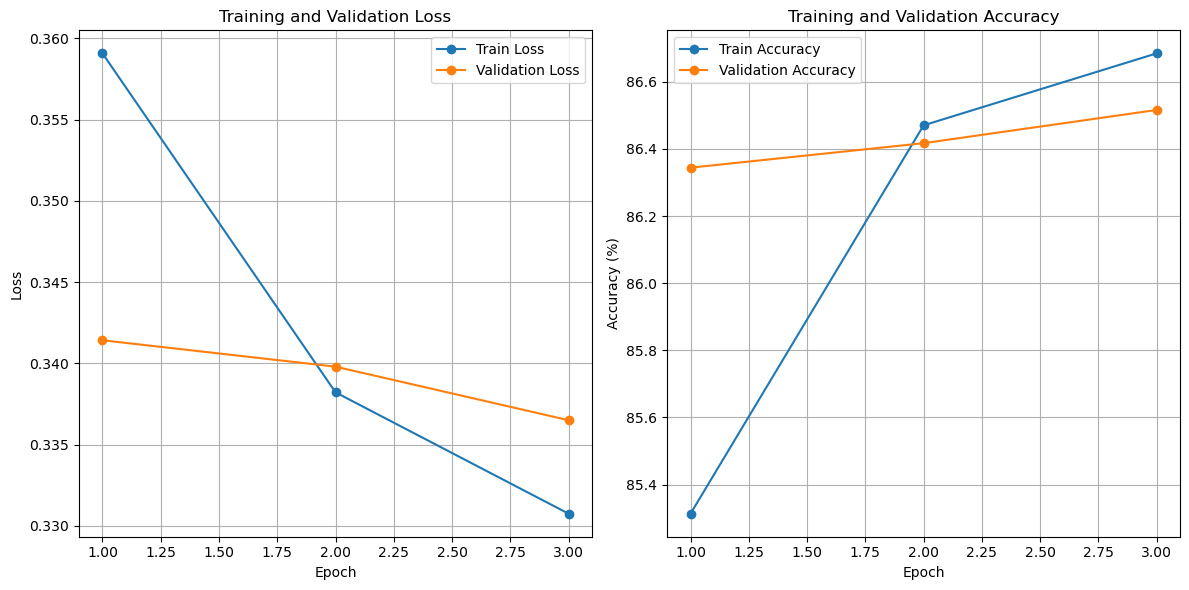

In [22]:
best_config, best_history, best_model = run_grid_search(df_train_ekman, df_val_ekman, vocab)
plot_training_history(best_history)



In [23]:
from sklearn.metrics import classification_report

# Unpack the best configuration
best_config, best_history, best_model = run_grid_search(df_train_ekman, df_val_ekman, vocab)

# Prepare test loader using the best batch size
_, best_batch_size, _ = best_config
test_loader = DataLoader(EmotionDataset(df_test_ekman), batch_size=best_batch_size, collate_fn=collate_fn)

# Evaluate on test set
best_model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = best_model(X_batch)
        preds = (outputs > 0.5).float()
        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert to arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Define class names
class_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Print detailed classification report
print("\nClassification Report (Multi-label, Test Set):")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))




  0%|          | 0/8 [00:00<?, ?it/s]


Training: hidden_dim=64, batch_size=16, epochs=3
Epoch 1/3 | Train Loss: 0.3628, Val Loss: 0.3502, Train Acc: 85.17%, Val Acc: 85.97%
Epoch 2/3 | Train Loss: 0.3378, Val Loss: 0.3398, Train Acc: 86.37%, Val Acc: 86.29%


 12%|█▎        | 1/8 [01:04<07:30, 64.35s/it]

Epoch 3/3 | Train Loss: 0.3245, Val Loss: 0.3371, Train Acc: 86.92%, Val Acc: 86.48%

Training: hidden_dim=64, batch_size=16, epochs=10
Epoch 1/10 | Train Loss: 0.3693, Val Loss: 0.3614, Train Acc: 84.35%, Val Acc: 85.00%
Epoch 2/10 | Train Loss: 0.3539, Val Loss: 0.3537, Train Acc: 85.45%, Val Acc: 85.53%
Epoch 3/10 | Train Loss: 0.3427, Val Loss: 0.3547, Train Acc: 86.05%, Val Acc: 85.62%
Epoch 4/10 | Train Loss: 0.3339, Val Loss: 0.3581, Train Acc: 86.40%, Val Acc: 85.41%
Epoch 5/10 | Train Loss: 0.3276, Val Loss: 0.3557, Train Acc: 86.70%, Val Acc: 85.52%
Epoch 6/10 | Train Loss: 0.3216, Val Loss: 0.3582, Train Acc: 87.01%, Val Acc: 85.52%
Epoch 7/10 | Train Loss: 0.3152, Val Loss: 0.3643, Train Acc: 87.27%, Val Acc: 84.98%
Epoch 8/10 | Train Loss: 0.3106, Val Loss: 0.3624, Train Acc: 87.55%, Val Acc: 85.28%
Epoch 9/10 | Train Loss: 0.3074, Val Loss: 0.3589, Train Acc: 87.74%, Val Acc: 85.34%


 25%|██▌       | 2/8 [04:14<13:49, 138.27s/it]

Epoch 10/10 | Train Loss: 0.3050, Val Loss: 0.3651, Train Acc: 87.80%, Val Acc: 85.14%

Training: hidden_dim=64, batch_size=32, epochs=3
Epoch 1/3 | Train Loss: 0.3708, Val Loss: 0.3643, Train Acc: 84.41%, Val Acc: 84.73%
Epoch 2/3 | Train Loss: 0.3493, Val Loss: 0.3445, Train Acc: 85.71%, Val Acc: 86.21%


 38%|███▊      | 3/8 [04:51<07:41, 92.20s/it] 

Epoch 3/3 | Train Loss: 0.3296, Val Loss: 0.3408, Train Acc: 86.67%, Val Acc: 86.32%

Training: hidden_dim=64, batch_size=32, epochs=10
Epoch 1/10 | Train Loss: 0.3711, Val Loss: 0.3584, Train Acc: 84.44%, Val Acc: 85.30%
Epoch 2/10 | Train Loss: 0.3446, Val Loss: 0.3417, Train Acc: 86.07%, Val Acc: 86.29%
Epoch 3/10 | Train Loss: 0.3259, Val Loss: 0.3375, Train Acc: 86.85%, Val Acc: 86.30%
Epoch 4/10 | Train Loss: 0.3099, Val Loss: 0.3393, Train Acc: 87.44%, Val Acc: 86.09%
Epoch 5/10 | Train Loss: 0.3003, Val Loss: 0.3435, Train Acc: 87.96%, Val Acc: 85.81%
Epoch 6/10 | Train Loss: 0.2899, Val Loss: 0.3430, Train Acc: 88.40%, Val Acc: 86.09%
Epoch 7/10 | Train Loss: 0.2807, Val Loss: 0.3495, Train Acc: 88.86%, Val Acc: 85.95%
Epoch 8/10 | Train Loss: 0.2732, Val Loss: 0.3498, Train Acc: 89.26%, Val Acc: 85.85%
Epoch 9/10 | Train Loss: 0.2655, Val Loss: 0.3516, Train Acc: 89.54%, Val Acc: 85.80%


 50%|█████     | 4/8 [06:52<06:53, 103.29s/it]

Epoch 10/10 | Train Loss: 0.2592, Val Loss: 0.3542, Train Acc: 89.84%, Val Acc: 85.79%

Training: hidden_dim=128, batch_size=16, epochs=3
Epoch 1/3 | Train Loss: 0.3568, Val Loss: 0.3407, Train Acc: 85.36%, Val Acc: 86.36%
Epoch 2/3 | Train Loss: 0.3347, Val Loss: 0.3340, Train Acc: 86.57%, Val Acc: 86.64%


 62%|██████▎   | 5/8 [08:12<04:45, 95.22s/it] 

Epoch 3/3 | Train Loss: 0.3260, Val Loss: 0.3317, Train Acc: 86.91%, Val Acc: 86.66%

Training: hidden_dim=128, batch_size=16, epochs=10
Epoch 1/10 | Train Loss: 0.3663, Val Loss: 0.3535, Train Acc: 84.67%, Val Acc: 85.51%
Epoch 2/10 | Train Loss: 0.3430, Val Loss: 0.3447, Train Acc: 86.11%, Val Acc: 86.18%
Epoch 3/10 | Train Loss: 0.3319, Val Loss: 0.3414, Train Acc: 86.63%, Val Acc: 86.26%
Epoch 4/10 | Train Loss: 0.3225, Val Loss: 0.3402, Train Acc: 87.00%, Val Acc: 86.31%
Epoch 5/10 | Train Loss: 0.3183, Val Loss: 0.3447, Train Acc: 87.10%, Val Acc: 86.02%
Epoch 6/10 | Train Loss: 0.3136, Val Loss: 0.3439, Train Acc: 87.34%, Val Acc: 85.94%
Epoch 7/10 | Train Loss: 0.3063, Val Loss: 0.3436, Train Acc: 87.69%, Val Acc: 86.13%
Epoch 8/10 | Train Loss: 0.3019, Val Loss: 0.3425, Train Acc: 87.89%, Val Acc: 86.17%
Epoch 9/10 | Train Loss: 0.2979, Val Loss: 0.3459, Train Acc: 88.14%, Val Acc: 86.06%


 75%|███████▌  | 6/8 [12:23<04:56, 148.06s/it]

Epoch 10/10 | Train Loss: 0.2942, Val Loss: 0.3481, Train Acc: 88.32%, Val Acc: 86.00%

Training: hidden_dim=128, batch_size=32, epochs=3
Epoch 1/3 | Train Loss: 0.3686, Val Loss: 0.3513, Train Acc: 84.50%, Val Acc: 85.78%
Epoch 2/3 | Train Loss: 0.3384, Val Loss: 0.3344, Train Acc: 86.36%, Val Acc: 86.61%


 88%|████████▊ | 7/8 [13:23<01:59, 119.34s/it]

Epoch 3/3 | Train Loss: 0.3233, Val Loss: 0.3345, Train Acc: 87.04%, Val Acc: 86.61%

Training: hidden_dim=128, batch_size=32, epochs=10
Epoch 1/10 | Train Loss: 0.3676, Val Loss: 0.3520, Train Acc: 84.69%, Val Acc: 85.87%
Epoch 2/10 | Train Loss: 0.3399, Val Loss: 0.3378, Train Acc: 86.38%, Val Acc: 86.44%
Epoch 3/10 | Train Loss: 0.3269, Val Loss: 0.3353, Train Acc: 86.91%, Val Acc: 86.63%
Epoch 4/10 | Train Loss: 0.3150, Val Loss: 0.3376, Train Acc: 87.36%, Val Acc: 86.36%
Epoch 5/10 | Train Loss: 0.3071, Val Loss: 0.3339, Train Acc: 87.72%, Val Acc: 86.48%
Epoch 6/10 | Train Loss: 0.2980, Val Loss: 0.3387, Train Acc: 88.10%, Val Acc: 86.24%
Epoch 7/10 | Train Loss: 0.2902, Val Loss: 0.3397, Train Acc: 88.44%, Val Acc: 86.31%
Epoch 8/10 | Train Loss: 0.2831, Val Loss: 0.3426, Train Acc: 88.77%, Val Acc: 86.16%
Epoch 9/10 | Train Loss: 0.2758, Val Loss: 0.3472, Train Acc: 89.09%, Val Acc: 85.98%


100%|██████████| 8/8 [16:28<00:00, 123.50s/it]

Epoch 10/10 | Train Loss: 0.2693, Val Loss: 0.3521, Train Acc: 89.32%, Val Acc: 85.94%

✅ Best configuration:
Hidden Dim: 128, Batch Size: 16, Epochs: 3
Validation Accuracy: 86.66%



Classification Report (Multi-label, Test Set):
              precision    recall  f1-score   support

       anger       0.12      0.00      0.00      1588
     disgust       0.00      0.00      0.00       258
        fear       0.00      0.00      0.00       254
         joy       0.77      0.57      0.65      4728
     neutral       0.32      0.02      0.04      3144
     sadness       0.40      0.01      0.02      1010
    surprise       0.54      0.19      0.28      1608

   micro avg       0.71      0.24      0.36     12590
   macro avg       0.31      0.11      0.14     12590
weighted avg       0.48      0.24      0.29     12590
 samples avg       0.26      0.25      0.25     12590

